In [ ]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

: 

In [ ]:


import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate_positive import J, J_prime

%load_ext autoreload
%autoreload 2

: 

In [ ]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/aerial"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/aerial/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

: 

In [ ]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


: 

In [ ]:
config

: 

In [ ]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

: 

In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


1500it [01:40, 14.94it/s]


In [10]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

2300it [01:22, 28.00it/s]


In [11]:
test_res_emb.shape

(2300, 1024)

In [12]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [13]:
cal_labels.shape, cal_res_emb.shape, cal_pred_probas.shape

((1221, 64, 64), (1221, 1024), (1221, 64, 64))

In [14]:
cal_labels.max(), cal_pred_probas.max()

(1.0, 0.9999030828475952)

In [15]:
ALPHA = .05
N = len(cal_labels)


In [17]:
result = minimize(
    J, np.random.uniform(0, 1, EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N), jac=J_prime,
    options={"disp": True, "maxiter": 1000}
    
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2


In [27]:
result.x.max()

1.0360946654884515

In [19]:
# ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)

In [30]:
ths.max()

-1.6064168978884923

In [31]:
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)

/tmp/ipykernel_1434558/1774683259.py:2: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)


In [32]:
y_pred_test_th.min()

1

In [22]:
np.nanmean(recall_test)

1.0

In [23]:
np.nanmean((y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2)))

/tmp/ipykernel_1434558/1952651966.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean((y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2)))


1.0

In [24]:
np.nanmean(recall_test), 1 - ALPHA + 1/N

(1.0, 0.9508190008190007)

In [25]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

0.14844875169836957

(array([ 1.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,
         2.,  1.,  2.,  1.,  4.,  2.,  1.,  2.,  4.,  4.,  6.,  4.,  6.,
         9.,  2.,  4., 10.,  9.,  4., 14., 11., 12., 10., 15., 12., 16.,
        16., 12., 19., 15., 16., 19., 19., 14., 12., 18., 16., 25., 30.,
        25., 24., 17., 25., 30., 30., 32., 23., 19., 30., 30., 48., 39.,
        62., 50., 44., 56., 51., 51., 63., 68., 57., 67., 74., 79., 68.,
        87., 87., 80., 65., 69., 50., 56., 33., 32., 31., 28., 25., 19.,
        14., 11., 13.,  9.,  9.,  4.,  3.,  3.,  2.]),
 array([-3.00005223, -2.98611588, -2.97217953, -2.95824317, -2.94430682,
        -2.93037047, -2.91643411, -2.90249776, -2.88856141, -2.87462505,
        -2.8606887 , -2.84675235, -2.83281599, -2.81887964, -2.80494329,
        -2.79100693, -2.77707058, -2.76313423, -2.74919787, -2.73526152,
        -2.72132517, -2.70738881, -2.69345246, -2.67951611, -2.66557975,
        -2.6516434 , -2.63770705, -2.62377069, -2.60983434, -2.595897

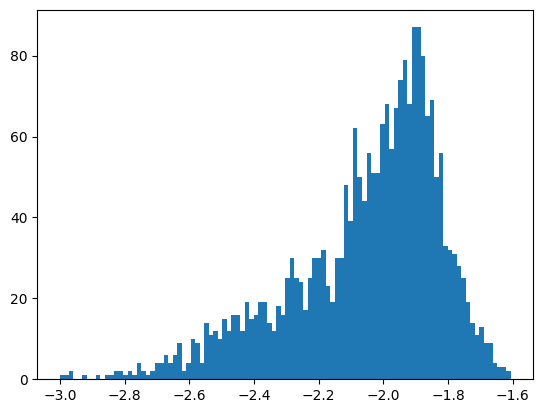

In [26]:
plt.hist(ths[:, 0, 0], bins=100)

(array([962., 585., 435., 181., 100.,  30.,   3.,   3.,   0.,   1.]),
 array([0.        , 0.09946289, 0.19892578, 0.29838867, 0.39785156,
        0.49731445, 0.59677734, 0.69624023, 0.79570312, 0.89516602,
        0.99462891]),
 <BarContainer object of 10 artists>)

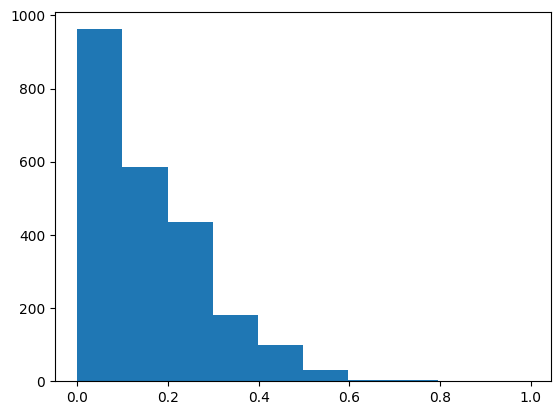

In [33]:
plt.hist(precision_test)

In [26]:
np.mean(precision_test)

0.6040416710626572

In [27]:
np.median(precision_test)

0.6907431478484878

In [28]:
if not os.path.exists(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME)):
    os.makedirs(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME))

np.save(os.path.join(BASE_DIR, "05_multiaccurate_results", MODEL_NAME, "theta.npy"), result.x)

In [29]:
result.x.shape

(1024,)

In [30]:
recalls = []
precisions = []
for th in tqdm(np.linspace(0, 1, 100)):
    pred_th = test_pred_probas >= th
    recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
    precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall))
    precisions.append(np.nanmean(precision))
    


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2911000/4188066551.py:5: RuntimeWarning: invalid value encountered in divide
  recall = (pred_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
/tmp/ipykernel_2911000/4188066551.py:6: RuntimeWarning: invalid value encountered in divide
  precision = np.nan_to_num((pred_th * test_labels).sum(axis=(1, 2)) / pred_th.sum(axis=(1, 2)), nan=1)
100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


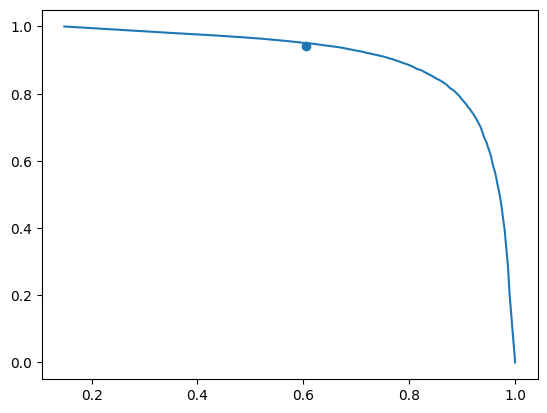

In [31]:
plt.plot(precisions, recalls)
plt.scatter(np.nanmean(precision_test), np.nanmean(recall_test))